<a href="https://colab.research.google.com/github/gbwiersum/CLApartmentScraper/blob/main/CLScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
#You might need these, install for your own system
#!pip install selenium -q
#!apt install chromium-chromedriver -y -q
import requests
from bs4 import BeautifulSoup
import os
import selenium
import math
from selenium import webdriver
from selenium.webdriver.common.by import By
import random
import time
import pandas as pd
import re

# Open a browser instance.
def start_browser():
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  browser = webdriver.Chrome('chromedriver', options=chrome_options)
  return(browser)

browser = start_browser()

In [178]:
#Gets all listings for a given search query. If I had a main, this would be it.
#Pages come in batches of 120. Pass "-1" to pages for all.
def get_listings(start_url, pages=-1):
  results = {}
  if pages == -1:
    end = 2880
  else:
    end = pages*120

  for n in range(0, end, 120):
    try:
      if True: #hasnextpage():
        if n>0:
          browser.get((start_url+'?s='+str(n)))
        else:
          browser.get(start_url)

        #Debug:
        pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
        pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
        print("Processing: "+pagestart+" through " + pageend)
        #####

        listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
        for l in listings:
          html = l.get_attribute('innerHTML')
          attributes = get_listing_attributes(html)
          results.update(attributes)
          time.sleep(random.randint(2,7))
        else:
          break
    except AttributeError:
      break

  results = pd.DataFrame.from_dict(results, orient = 'index')
  return results

#Rewriting results page into dictionary format
#Takes html string of individual search result, returns dictionary with CL unique ID as index.
def get_listing_attributes(html):
  url = BeautifulSoup(html).a.get('href')

  #todo: I think something's broken here - always returns null?
  try:
    price = BeautifulSoup(html).find('span', class_="result-price").text
    price = int(re.sub('[^0-9]','', price))
  except:
    price = None

  date = BeautifulSoup(html).find('time', class_="result-date").get('datetime')

  try:
    bed = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, after='br')
    bed = int(bed)
  except:
    bed=0

  try:
    sqft = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, before="", after="ft2")
    sqft = int(sqft)
  except:
    sqft=0

  heading = BeautifulSoup(html).find('a', class_="result-title hdrlnk").text
  id = BeautifulSoup(html).find('a', class_='result-title hdrlnk').get('data-id')

  return {id:[heading, url, price, date, bed, sqft]}


#utility to pull variables out of xml data using leading and following tag.
#I refusue to learn regex and this is my workaround for that.
def xml_getter(text, before="", after=""):
  m = re.search(before+'(.+?)'+after, text)
  if m:
      found = m.group(1).strip()
      return found


#TODO: This one I think is broken. Fix it.
#Utility to check for availability of next page.
#Returns true if page is available 
def hasnextpage():
  n=2
  while n<16:
    try:
      if BeautifulSoup(browser.page_source).find('a', class_='button next') != None:
        return True
      if (BeautifulSoup(browser.page_source).find('a', class_='button next') == None) & (BeautifulSoup(browser.page_source).find('a', class_='button pagenum')!= None):
        return False
      elif (BeautifulSoup(browser.page_source).find('a', class_='button pagenum')== None) & (n<8):
        time.sleep(n)
        n=n*2
        if n > 4:
          browser.refresh()
          time.sleep(10)
          return BeautifulSoup(browser.page_source).find('a', class_='button next') != None
        else:
          print("Nobody's supposed to see this dialog. Please contact project manager.")
          return False
    except Exception as ex:
      print(ex.args)
      print("Attempt to pull next page threw an exception. Please restart application")
      return False


#Gets attributes from specific listings. Returns a pandas series of attributes not listed in top-line search results
#TODO: add a progress bar
#TODO: run in batches, maybe a little more randomly so you don't get booted.
def get_listing_details(url):
  #TODO: Parking isn't worknig, beds and baths return str.
  attrvals = []
  try:
    browser.get(url)
    pagesource = BeautifulSoup(browser.page_source)
    text = pagesource.find_all('p', class_='attrgroup')[1].text

    #Parking spaces, baths, description body, latitude and longitude
    park = re.search('\n(.+?)parking(.+?)\n', text)

    bedbath = pagesource.find('span', class_='shared-line-bubble').text
    beds = float(xml_getter(bedbath, before='', after = "BR"))
    baths = float(xml_getter(bedbath, before="/ ", after='Ba'))

    body = BeautifulSoup(browser.page_source).find('section', id='postingbody').text

    try:  
      lat = pagesource.find('div', id='map').get('data-latitude')
      lon = pagesource.find('div', id='map').get('data-longitude')
    except AttributeError:
      lat=None
      lon=None

    attrvals.extend((beds, baths, park, body, lat, lon))

    #Dogs/cats allowed, laundry situation:
    for attr in ['dog', 'cat', 'laundry']:
      try:
        spattr = re.search('\n'+attr+'(.+?)\n', text)
        attrvals.append(attr+spattr.group(1))
      except:
        attrvals.append(None)

    return(pd.Series(attrvals))

  except:
    print("An error was encountered. ")
    return pd.Series(attrvals)

In [180]:
browser.quit()
start_browser()
browser.get('https://chicago.craigslist.org/search/apa')

MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=59475): Max retries exceeded with url: /session/9e9749fc372dd25d01c54465e9e07769/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fbe8527b9a0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [173]:
listingdf = get_listings('https://chicago.craigslist.org/search/apa')
listingdf.columns = ['heading', 'url', 'rent', 'date posted', 'beds', 'sqft']

#Todo: get_listing_details will have to be run on subsets, not the entire dataset.
#Figure out how to run this without getting banned from craigslist for being too creepy.
#Run one day at a time? add a sleep(n)-variable to make you look more human?

Processing: 1 through 120


In [174]:
attributes = listingdf['url'].apply(lambda x: get_listing_details(x))
listingdf = listingdf.merge(attributes)
listingdf.drop(columns = 'beds', inplace = True)
listingdf.drop_duplicates()
listingdf.columns = ['heading', 'url', 'rent','date', 'sqft', 'beds', 'baths', 'parking', 'text', 'lat', 'lon', 'dogs', 'cats', 'laundry']

An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 


<ipython-input-172-2692ccb6bed0>:146: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(attrvals)


An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 
An error was encountered. 


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [109]:
listingdf[['heading','sqft','beds', 'baths']].drop_duplicates()

,heading,sqft,beds,baths
0,Come Home With Pride.,917,2,2.0
1,1 and 2-Bedroom Affordable Senior Community,680,1,1.0
2,"Affordable Studio, 1 & 2- Bedroom Senior/Disab...",623,1,1.0
3,Limited Availability!,820,2,1.0
4,Everything You Want Plus More! Call Plum Creek...,650,1,1.0
...,...,...,...,...
3535,3 beds and 1.5 baths house,1634,3,1.5
3536,Move In Special This Week Only!,0,1,1.0
3537,Upgraded 4 Bedroom House In Amarillo,3300,4,3.0
3538,Updated 3 Bedroom House In Amarillo,1501,3,2.0


In [ ]:
#if savefile is specified? ...if they want to save it?
listingdf.to_csv('./CLScraped.csv')

# Analysis

In [122]:
#df=pd.read_csv('./CLScraped.csv')
listingdf.drop_duplicates(inplace = True)
dummy = listingdf[['rent','sqft', 'beds', 'baths', 'parking', 'lat', 'lon', 'dogs', 'cats', 'laundry']]
dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
dummy['beds']=dummy['beds']/max(dummy['beds'])
dummy['dogs'].fillna(0, inplace=True)
dummy['dogs'].replace("dogs are OK - wooof", 1, inplace=True)
dummy['cats'].fillna(0, inplace=True)
dummy['cats'].replace('cats are OK - purrr', 1, inplace = True)
dummy['laundry'].replace('laundry in bldg', 1, inplace=True)
dummy["laundry"].replace('laundry on site', 1, inplace=True)
dummy['laundry'].fillna(0, inplace=True)
dummy[dummy['parking'].notnull()]['parking']=1
dummy['parking'].fillna(0, inplace=True)
dummy['sqft'].replace(0, None)
dummy['sqft'] = dummy['sqft']/dummy['sqft'].max()
dummy['baths']=dummy['baths']/max(dummy['baths'])

<ipython-input-122-8665ff512ad4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
<ipython-input-122-8665ff512ad4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy['beds']=dummy['beds']/max(dummy['beds'])
/Users/grant/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [123]:
dummy

,rent,sqft,beds,baths,parking,lat,lon,dogs,cats,laundry
0,0.1892,0.277879,0.4,0.666667,0,35.184044,-101.815991,1,1,0.0
1,0.1700,0.206061,0.2,0.333333,0,35.197700,-101.894900,0,0,1.0
2,0.1832,0.188788,0.2,0.333333,0,35.160374,-101.881053,0,0,1.0
3,0.2020,0.248485,0.4,0.333333,0,35.225534,-101.815156,1,1,1.0
4,0.1296,0.196970,0.2,0.333333,0,35.270300,-101.943000,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...
3535,0.2720,0.495152,0.6,0.500000,0,35.210072,-101.881581,1,1,0.0
3536,0.1320,0.000000,0.2,0.333333,0,35.225534,-101.815156,1,1,1.0
3537,0.3920,1.000000,0.8,1.000000,0,35.166300,-101.886800,1,1,0.0
3538,0.3120,0.454848,0.6,0.666667,0,35.166300,-101.886800,1,1,0.0


<AxesSubplot:>

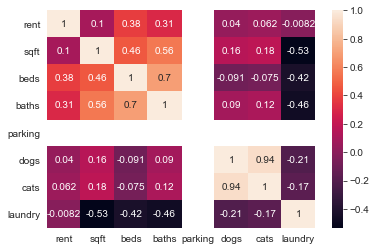

In [124]:
import seaborn as sns
sns.heatmap(dummy.corr(), annot=True)

/Users/grant/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/grant/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='sqft', ylabel='rent'>

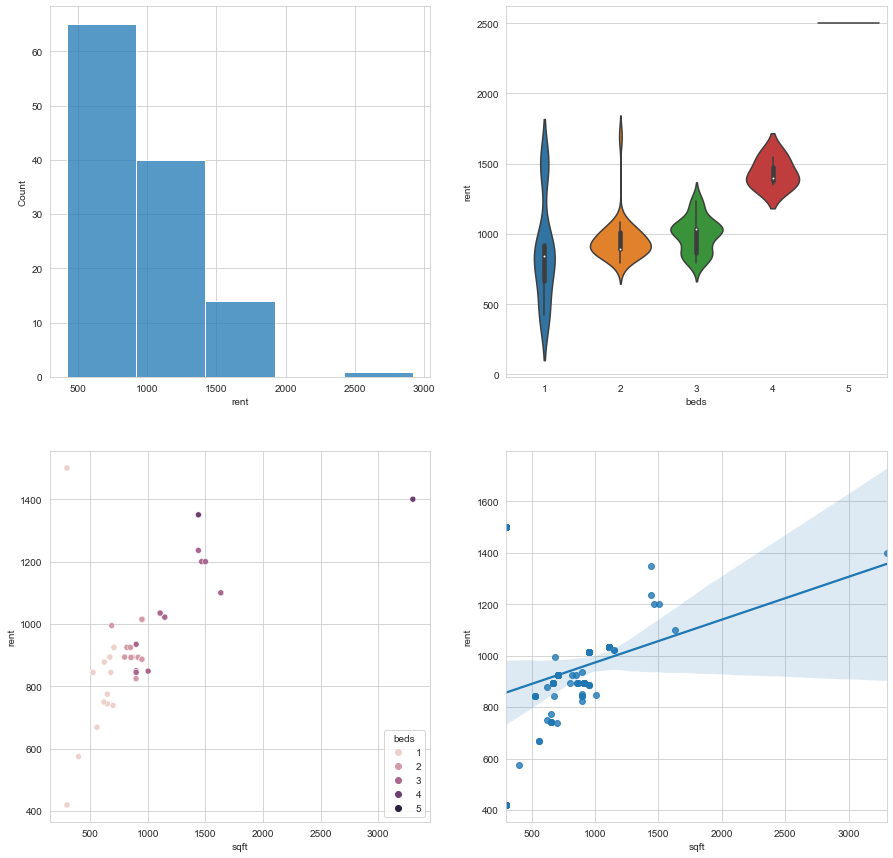

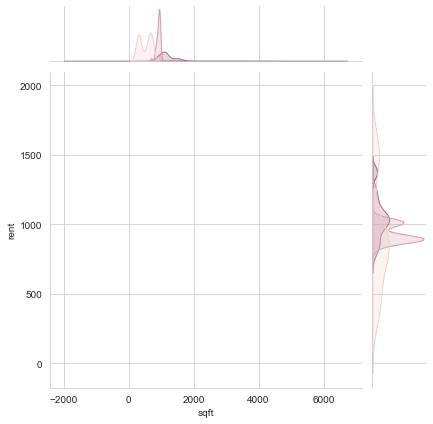

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(2,2 , figsize=(15, 15))
sns.histplot(ax=axes[0,0], data=listingdf['rent'], binwidth=500)
sns.violinplot(ax=axes[0,1], x=listingdf["beds"], y=listingdf["rent"])
sns.jointplot(ax=axes[1,0], x=listingdf[listingdf['sqft']>10]['sqft'], y=listingdf[listingdf['sqft']>10]['rent'], hue=listingdf['beds'])
sns.regplot(ax=axes[1,1], x=listingdf[listingdf['sqft']>10]['sqft'], y=listingdf[listingdf['sqft']>10]['rent'])

In [168]:
from scipy import stats
maxz = stats.zscore((listingdf['rent']/listingdf[listingdf['sqft']>0]['sqft']).dropna()).max()
print(maxz)
print(stats.norm.ppf(maxz))
print((listingdf['rent']/listingdf[listingdf['sqft']>0]['sqft']).dropna().max())

2.8320730880126366
nan
5.0


In [169]:
stats.norm.ppf(maxz)

2.8320730880126366

In [112]:
from scipy.stats import linregress
slope, intercept, r, p, se = linregress(x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['rent'])
print(slope*2100+intercept)

946.6374923596347


In [170]:
np.random()

NameError: name 'np' is not defined

In [ ]:

#For scraping historical data:

for i in links:
	soup = BeautifulSoup(requests.get(i).content, 'html.parser')
	date_plus = str(soup).split("web/",1)[1].split("/http",1)[0]
	historic_scrape(0,soup,date_plus)
	print("***** Link" + str(i) + "completed *****")

def get_links(years=["2020", "2021", "2022"]):

  # List the years you'll loop over
  years = ["2020", "2021", "2022"]
  # And instantiate a list we'll put links in
  linklist = []

  for y in years:
    try:
      calpage = "https://web.archive.org/web/" + str(y) + "0101000000*/http://www.chicago.craigslist.org/search/apa"
      browser.get(calpage)  # doing this twice ensures that it loads correctly
      browser.get(calpage)
      time.sleep(1)
      try:
        cal = browser.find_elements(by=By.CLASS_NAME, value='calendar-day')
      except:
        time.sleep(3) # sometimes the browser loads slowly--just try again
        cal = browser.find_elements(by=By.CLASS_NAME, value='calendar-day')
      for c in cal:
        html = c.get_attribute("innerHTML") # get the calendar's html content
        soup = BeautifulSoup(html, 'html.parser') # turn it into a soup
        link = str(soup.a) # the name of the chunk containing links
        url = "https://web.archive.org" + link.split('"', 1)[1].split('"',1)[0]
        if url not in linklist: # if we don't already have it, add it to the list
          linklist.append(url)
    except:  # if a page does not exist, continue to the next one
      continue
  return(linklist)

links = get_links()
links.append("https://chicago.craigslist.org/search/apa") #Add current day's listings

start_url = 'https://chicago.craigslist.org/search/apa'
pages = -1

results = {}
if pages == -1:
  end = 2880
else:
  end = pages*120

for n in range(0, end, 120):
    if True: #hasnextpage():
      if n>0:
        browser.get((start_url+'?s='+str(n)))
      else:
        browser.get(start_url)

      #Debug: 
      pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
      pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
      print("Processing: "+pagestart+" through " + pageend)
      #####

      listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
      for l in listings:
        html = l.get_attribute('innerHTML')
        attributes = get_listing_attributes(html)
        results.update(attributes)
    else:
      break

len(listings)
pd.DataFrame(results)